In [5]:
# import torch
import numpy as np
import data_pipes

df_path = "processed_aapl_data.csv"
data = data_pipes.process_df_2(df_path)

In [2]:
from torch import nn

class georgia_1(nn.Module):
    def __init__(self, config, win_past=20, features=19, bias=False):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Flatten())

        for idx in range(len(config['neurons'])):
            if config['activations'][idx] == 'relu':
                activation = nn.ReLU()
            elif config['activations'][idx] == 'selu':
                activation = nn.SELU()
            elif config['activations'][idx] == 'sigmoid':
                activation = nn.Sigmoid()
            elif config['activations'][idx] == 'tanh':
                activation = nn.Tanh()
            elif config['activations'][idx] == 'none':
                activation = "none"
            else:
                raise ValueError(f"Unrecognized activation function at index {idx}: {config['activations'][idx]}")

            if idx == 0:
                self.layers.append(nn.Linear(features*win_past, config['neurons'][idx], bias=bias))
            else:
                self.layers.append(nn.Linear(config['neurons'][idx - 1], config['neurons'][idx], bias=bias))

            if activation != 'none':
                self.layers.append(activation)

            self.layers.append(nn.Dropout(config['dropouts'][idx]))
        
        # self.init_weights()
        
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                
                nn.init.trunc_normal_(m.weight, mean=0, std=1)  # Set mean=0, std=1
                if m.bias is not None:
                    nn.init.zeros_(m.bias)  # Optional: Initialize biases to 0

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        return x

In [ ]:
a = x[0]
a

In [7]:
import time
import torch
from torch import optim
import torch_ops as ops
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

x, y = data["x"], data["y"]
v_split = 0.8
v_cutoff = int(len(x)*v_split)
x_t = torch.tensor(x[:v_cutoff], dtype=torch.float32).to(device)
x_v = torch.tensor(x[v_cutoff:], dtype=torch.float32).to(device)
y_t = torch.tensor(y[:v_cutoff], dtype=torch.float32).to(device)
y_v = torch.tensor(y[v_cutoff:], dtype=torch.float32).to(device)

win_past, features = x.shape[1], x.shape[2]

epochs = 2000
batch_size = 32
lr = 2e-6
l2_decay = 0

rate_schedule = ops.rate_schedule_cosine(
    rate_max=1e-3,
    rate_min=1e-6,
    epochs=epochs,
    decay_param=1e-2)

best_score = 1
scores = []
verbose = True
for iteration in range(1):
    # model_config = random_model_config()
    model_config = {
        'neurons': [512, 1],
        'activations': ['selu', 'none'],
        'dropouts': [0.0, 0.0]
    }

    model = georgia_1(
        model_config,
        win_past=win_past,
        features=features,
        bias=True
        ).to(device)
    
    optimizer = optim.NAdam(
        params=model.parameters(),
        lr=lr,
        # weight_decay=l2_decay
        )
    
    loss_fn = nn.L1Loss()

    if verbose:
        loss = ops.test_loop(x_t, y_t, model, loss_fn, batch_size)
        test_loss = ops.test_loop(x_v, y_v, model, loss_fn, batch_size)
        print("---------- Epoch 0 ----------")
        print(f"loss: {loss:1.4f}, test loss: {test_loss:1.4f}")

    best_test_loss = 999
    t0 = time.perf_counter()
    for epoch in range(epochs):
        # for param_group in optimizer.param_groups:
        #     param_group['lr'] = rate_schedule[epoch]
        loss = ops.train_loop(x_t, y_t, model, loss_fn, optimizer, batch_size)
        print(f"epoch: {epoch}, loss: {loss:1.4f}")
        # test_loss_new = ops.test_loop(x_v, y_v, model, loss_fn, batch_size)
        # best_test_loss = min(best_test_loss, test_loss_new)

        # if verbose:
        #     if test_loss_new < test_loss or epoch == epochs - 1:
        #         print(f"---------- Epoch {epoch + 1} ----------")
        #         print(f"loss: {loss:1.4f}, test loss: {test_loss_new:1.4f}")
            
        #     improvement = test_loss_new < test_loss
        #     if improvement:
        #         test_loss = test_loss_new
        #         print(f"Checkpoint: test loss = {test_loss:1.4f} <---------------")
        #         torch.save(model.state_dict(), r"models/hanzo_0")

    t1 = time.perf_counter()
    model_config['score'] = best_test_loss
    scores.append(model_config)
    best_score = min(best_score, best_test_loss)

    print(f"Iteration {iteration}, t = {t1 - t0:1.2f}, score = {best_test_loss:1.4f}, best score = {best_score:1.4f}")

---------- Epoch 0 ----------
loss: 0.1870, test loss: 0.1447
epoch: 0, loss: 0.0687
epoch: 1, loss: 0.0681
epoch: 2, loss: 0.0677
epoch: 3, loss: 0.0673
epoch: 4, loss: 0.0669
epoch: 5, loss: 0.0665
epoch: 6, loss: 0.0661
epoch: 7, loss: 0.0657
epoch: 8, loss: 0.0653
epoch: 9, loss: 0.0648
epoch: 10, loss: 0.0645
epoch: 11, loss: 0.0641
epoch: 12, loss: 0.0637
epoch: 13, loss: 0.0633
epoch: 14, loss: 0.0628
epoch: 15, loss: 0.0624
epoch: 16, loss: 0.0620
epoch: 17, loss: 0.0616
epoch: 18, loss: 0.0611
epoch: 19, loss: 0.0607
epoch: 20, loss: 0.0603
epoch: 21, loss: 0.0598
epoch: 22, loss: 0.0594
epoch: 23, loss: 0.0589
epoch: 24, loss: 0.0585
epoch: 25, loss: 0.0580
epoch: 26, loss: 0.0576
epoch: 27, loss: 0.0571
epoch: 28, loss: 0.0567
epoch: 29, loss: 0.0562
epoch: 30, loss: 0.0558
epoch: 31, loss: 0.0554
epoch: 32, loss: 0.0550
epoch: 33, loss: 0.0546
epoch: 34, loss: 0.0542
epoch: 35, loss: 0.0538
epoch: 36, loss: 0.0534
epoch: 37, loss: 0.0530
epoch: 38, loss: 0.0526
epoch: 39, l

<Figure size 640x480 with 0 Axes>

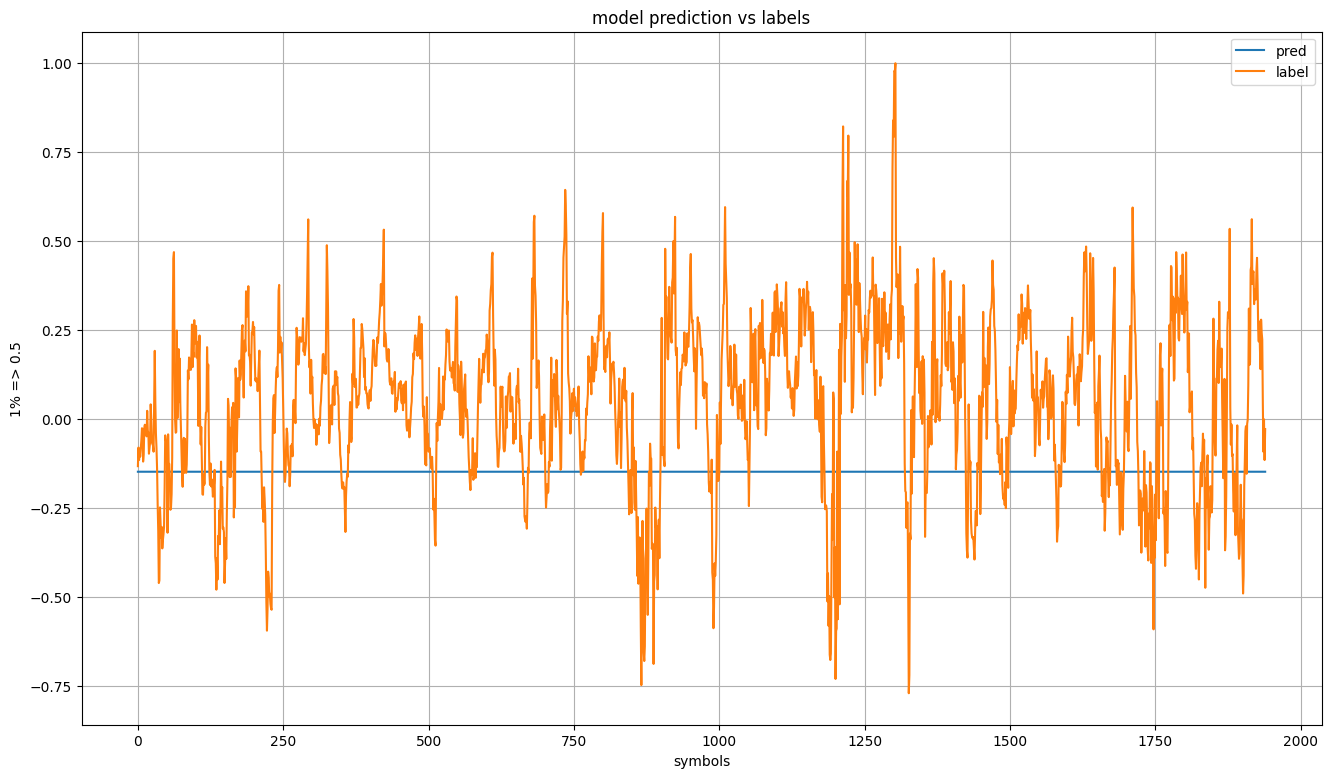

In [8]:
from matplotlib import pyplot as plt

# pred = model(x_v).to('cpu').detach().numpy()
# label = y_v.to('cpu').detach().numpy()

pred = model(x_t).to('cpu').detach().numpy() * 3
label = y_t.to('cpu').detach().numpy()

sym_index = np.arange(pred.shape[1])

fig = plt.figure()
plt.figure(figsize=(16, 9))
plt.title("model prediction vs labels")
plt.xlabel("symbols")
plt.ylabel("1% => 0.5")

plt.plot(pred, label="pred")
plt.plot(label, label="label")

plt.grid()
plt.legend()
plt.show()